In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import mahalanobis, cityblock, correlation, minkowski
from scipy.stats import mode
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.decomposition import PCA
from numpy.random import RandomState
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from time import time
import cv2
import os
from google.colab import drive
import math
import warnings
warnings.simplefilter('ignore')



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1. Load and visualize data

In [ ]:
def load_dataset(data_dir = '/content/drive/MyDrive/Face recognition/ATT images'):
    data=[]
    target=[]
    for i in range(1,41):
        images = os.listdir(f'{data_dir}/s'+str(i))
        for image in images:

            img = cv2.imread(f'{data_dir}/s'+str(i)+"/"+image,0)
            height1, width1 = img.shape[:2]
            # img_col = np.array(img, dtype='float64').flatten()
            img_col = np.array(img, dtype='float64')
            subject = int(i)
            data.append(img_col)
            target.append(subject)
    return np.array(data), np.array(target) - 1

In [ ]:
data, target = load_dataset()


In [ ]:
print("There are {} images in the dataset".format(len(data)))
print("There are {} unique targets in the dataset".format(len(np.unique(target))))
print("Size of each image is {}x{}".format(data.shape[1],data.shape[2]))
print(np.max(data), np.min(data))

There are 400 images in the dataset
There are 40 unique targets in the dataset
Size of each image is 112x92
251.0 0.0


In [ ]:
def show_40_distinct_people(images, unique_ids):
    #Creating 4X10 subplots in  18x9 figure size
    fig, axarr=plt.subplots(nrows=4, ncols=10, figsize=(18, 9))
    #For easy iteration flattened 4X10 subplots matrix to 40 array
    axarr=axarr.flatten()

    #iterating over user ids
    for unique_id in unique_ids:
        image_index=unique_id*10
        axarr[unique_id].imshow(images[image_index], cmap='gray')
        axarr[unique_id].set_xticks([])
        axarr[unique_id].set_yticks([])
        axarr[unique_id].set_title("face id:{}".format(unique_id))
    plt.suptitle("There are 40 distinct people in the dataset")

In [ ]:
show_40_distinct_people(data, np.unique(target))

In [ ]:
def show_10_faces_of_n_subject(images, subject_ids):
    # each subject has 10 distinct face images
    cols=10
    rows=(len(subject_ids)*10)/cols
    rows=int(rows)
    # rowsx10 dimensions
    # print('{} x {}'.format(rows, cols))

    fig, axarr=plt.subplots(nrows=rows, ncols=cols, figsize=(18,9))
    # axarr=axarr.flatten()

    for i, subject_id in enumerate(subject_ids):
        for j in range(cols):
            image_index=subject_id*10 + j
            axarr[i,j].imshow(images[image_index], cmap="gray")
            axarr[i,j].set_xticks([])
            axarr[i,j].set_yticks([])
            axarr[i,j].set_title("face id:{}".format(subject_id))

In [ ]:
show_10_faces_of_n_subject(images=data, subject_ids=[0, 5, 21, 24, 36])

### 2. Split the data

In [ ]:
# We reshape images for machine learnig  model
X = data.reshape((data.shape[0],data.shape[1]*data.shape[2]))
print("data shape:",data.shape)
print("X shape:",X.shape)

In [ ]:
X_train, X_test, y_train, y_test=train_test_split(X, target, test_size=0.3, stratify=target, random_state=0)
print("X_train shape:",X_train.shape)
print("y_train shape:",y_train.shape)
print("X_test shape:",X_test.shape)
print("y_test shape:",y_test.shape)

In [ ]:
y_frame=pd.DataFrame()
y_frame['subject ids']=y_train
y_frame.groupby(['subject ids']).size().plot.bar(figsize=(15,8),title="Number of Samples for Each Classes")

### 3. Dimension Reduction Using PCA

In [ ]:
class PCA:
	# constructor
    def __init__(self, n):
        self.n = n                                      # The number of principal components to keep
        self.mean_data = None                           # The average face
        self.weights = None                             # The weights of each face
        self.eigenvalues = None                         # The eigenvalues of the covariance matrix
        self.principal_components = None                # The unit eigenvectors of the covariance matrix

    def fit(self, data):

        # Find the average face
        self.mean_data = np.mean(data, axis=0)

        # Subtract all the faces with the average face to center it
        data_adj = data - self.mean_data

        # Calculate the covariance matrix
        # Computing A*A.T speeds up calculation compared to A.T*A [transpose trick]
        C = 1/(len(data_adj) - 1) * np.matmul(data_adj, data_adj.T)

        # Find the eigenvalues and eigenvectors of the covariance matrix
        eigenvalues, eigenvectors = np.linalg.eig(C)

        # Sort them in descending order
        sorted_indices = np.argsort(eigenvalues.T)[::-1]
        self.eigenvalues = eigenvalues[sorted_indices]

        # Recovering the eigenfaces
        new_eigenvectors = np.matmul(data_adj.T, eigenvectors).T[sorted_indices]

        # Normalizing the eigenfaces
        self.principal_components = new_eigenvectors / np.linalg.norm(new_eigenvectors)

        # Save the weights
        self.weights = np.matmul(data_adj, self.principal_components.T)

    # transform the data according to the fitted model
    def transform(self, data):
        # center the data
        data_adj = data - self.mean_data

        components = self.principal_components[0:self.n]

        bool_arr = np.ones(len(components), dtype=bool)
        weights = np.matmul(data_adj, components[bool_arr].T)

        # return the weights that make up the face
        return weights

    # perform fitting and transforming at the same time
    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

    # show the mean face
    def show_mean(self):
        plt.title("Mean Image")
        plt.imshow(self.mean_data.reshape((112, 92)), cmap="gray")
        plt.show()

    # show the cumulative explained variance
    def show_explained_variance(self):
        total = sum(self.eigenvalues)
        cumulative_sum = [sum(self.eigenvalues[:i]) / total for i in range(self.n)]
        plt.plot(range(1, self.n + 1), cumulative_sum, linewidth=2)
        plt.title("Explained Variance")
        plt.xlabel("Number of Principle Components")
        plt.show()

    # show the eigenfaces
    def show_components(self):
      print(self.principal_components.shape)
      number_of_eigenfaces=len(self.principal_components)
      eigen_faces=self.principal_components.reshape((number_of_eigenfaces, 112, 92))[:50]
      cols=10
      rows=5
      fig, axarr=plt.subplots(nrows=rows, ncols=cols, figsize=(15,15))
      axarr=axarr.flatten()
      for i in range(50):
          axarr[i].imshow(eigen_faces[i],cmap="gray")
          axarr[i].set_xticks([])
          axarr[i].set_yticks([])
          axarr[i].set_title("eigen id:{}".format(i))
      plt.suptitle("All Eigen Faces".format(10*"=", 10*"="))

    # show all the metrics at the same time
    def show_metrics(self):
        self.show_mean()
        self.show_explained_variance()
        self.show_components()

In [ ]:
# Test with n_component = 1000 first
pca=PCA(n = 400)
pca.fit(X)
pca.show_explained_variance()

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <b>
        In the figure above, it can be seen that 90 and more PCA components represent the same data. Now let's make the classification process using 90 PCA components.
    </b>
<br>
</div>

In [ ]:
n_components=50
pca=PCA(n_components)
pca.fit(X_train)

- Show average face

In [ ]:
fig, ax=plt.subplots(1, 1, figsize=(8, 8))
pca.show_mean()

- Show eigenfaces: showing the first 90 eigenfaces

(280, 10304)


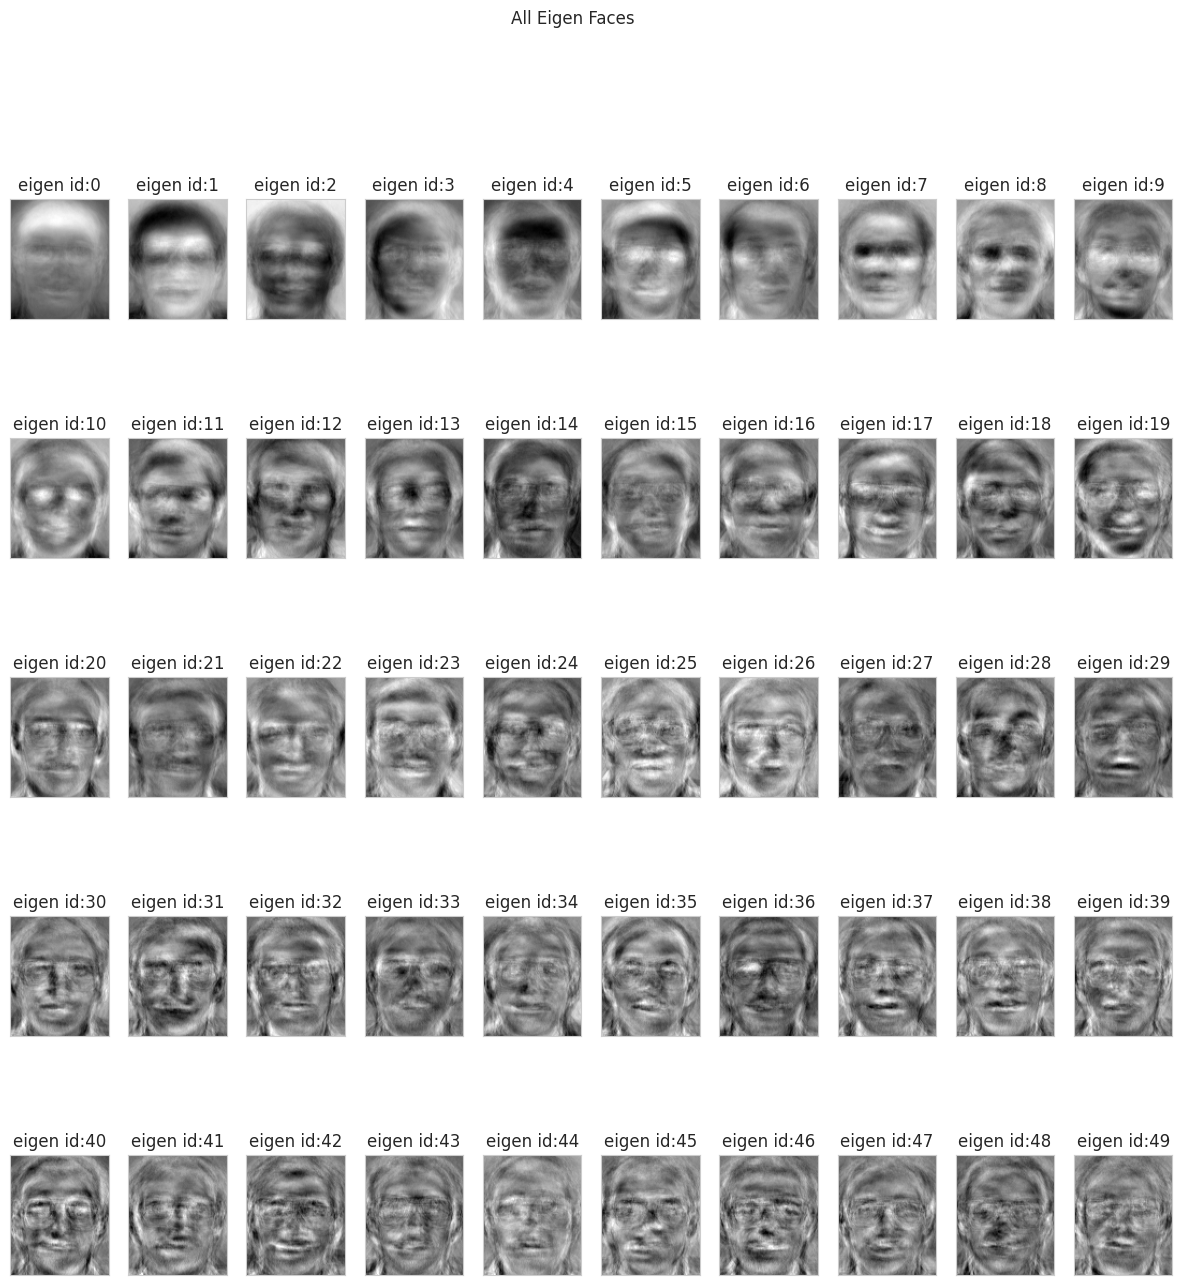

In [ ]:
pca.show_components()

### 4. Classification results

In [ ]:
def cal_distances(method, X, data):
    if method == 'euclidean':
      distances = np.linalg.norm(data - X, axis=1)

    elif method == 'angle-based':
      data = data.reshape((1, -1))
      distances = (-1) * cosine_similarity(X, data)
      distances = np.array(distances).squeeze()

    elif method == 'modified-sse':
      data = data.reshape((1, -1))
      distances = np.array([np.sum((data - x)**2) / (np.sum(x**2)*np.sum(data**2)) for x in X])

    elif method == 'mahalanobis':
      # https://stackoverflow.com/questions/53296903/how-to-find-mahalanobis-distance-between-two-1d-arrays-in-python
      inv_cov = np.linalg.inv(X.T@X)
      distances = np.array([mahalanobis(x, data,inv_cov) for x in X])
      # distances = np.array(mahalanobis(X, data.reshape((-1, 1)), np.linalg.inv(X.T@X)))

    elif method == 'manhattan':
      distances =  np.array([cityblock(x, data) for x in X])

    elif method == 'sse':
      distances =  np.array([np.sum((x-data)**2) for x in X])

    elif method == 'chi square':
      distances =  np.array([np.sum((x-data)**2 / (x - data)) for x in X])

    elif method == 'correlation coefficient-based':
      distances =  np.array([correlation(x, data) for x in X])
    elif method == 'minkowski':
      distances =  np.array([minkowski(x, data) for x in X])

    return distances

In [ ]:
class Distance_Classifier:
    # constructor
    def __init__(self, method):
        self.X = []     # the face vectors
        self.y = []     # the labels for those face vectors
        if method not in ['euclidean', 'angle-based', 'modified-sse', 'mahalanobis', 'manhattan', 'sse', 'chi square', 'correlation coefficient-based', 'minkowski' ]:
          raise Exception("Name of method should be in the list ['euclidean', 'angle-based', 'modified-sse', 'mahalanobis', 'manhattan', 'sse', 'chi square', 'correlation coefficient-based', 'minkowski ]")
        self.method = method

    # train the model
    def fit(self, X, y):
        self.X = X
        self.y = y

    # give the model a single face and get back a single prediction
    # if only_prediction is False, then more information will be returned as a dictionary (the index, and the distance)
    def predict_single(self, data, only_prediction=True):
        # find the distances of the sample from the training faces
        distances = cal_distances(self.method, self.X, data)

        index = np.argmin(distances)
        # print(index)
        # output the prediction based on the labels of the training faces and return a result

        prediction = self.y[index]

        if only_prediction:
            return prediction
        else:
            return {"prediction": prediction, "index": index, "distance": distances[index]}

    # predict a batch of faces at the same time, returns an array of predictions
    def predict(self, data):
        predictions = [self.predict_single(sample) for sample in data]
        return predictions

    def score(self, X_test, y_test):
        y_pred = self.predict(X_test)

        return accuracy_score(y_pred, y_test)

    def plot_best_match(self, X_train_origin, X_test_origin, X_test, y_test):
        incorrect_indices = []
        print('VISUALIZE ALL THE WRONGLY CLASSIFIED IMAGES')

        for i, data in enumerate(X_test):
            prediction_result = self.predict_single(data, only_prediction=False)
            best_match_index = prediction_result["index"]
            prediction = prediction_result["prediction"]

            if int(prediction) != int(y_test[i]):

                incorrect_indices.append(i)
                best_match_image = X_train_origin[best_match_index].reshape((112, 92))

                # Create a new figure for each subplot
                plt.figure(figsize=(10, 5))

                # Plot the original image on the left
                plt.subplot(1, 2, 1)
                plt.imshow(X_test_origin[i].reshape((112, 92)), cmap='gray')
                plt.title(f'Actual: {y_test[i]}')
                plt.tick_params(labelleft='off', labelbottom='off', bottom='off', top='off', right='off', left='off', which='both')

                # Plot the best match image on the right
                plt.subplot(1, 2, 2)
                plt.imshow(best_match_image, cmap='gray')
                plt.title(f'Best Match: {self.y[best_match_index]}')
                plt.tick_params(labelleft='off', labelbottom='off', bottom='off', top='off', right='off', left='off', which='both')


        # plt.subplots_adjust(right=1.2, top=len(incorrect_indices)*0.8)

        plt.show()



In [ ]:
X_train_pca=pca.transform(X_train)
X_test_pca=pca.transform(X_test)

accuracy score:95.83%
VISUALIZE ALL THE WRONGLY CLASSIFIED IMAGES


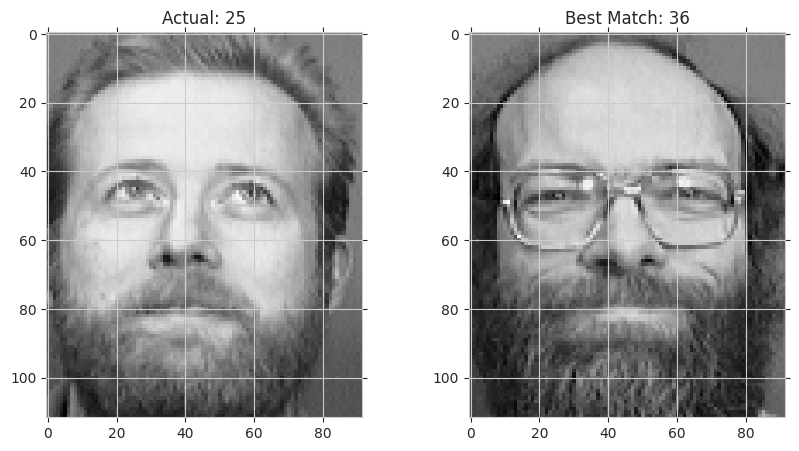

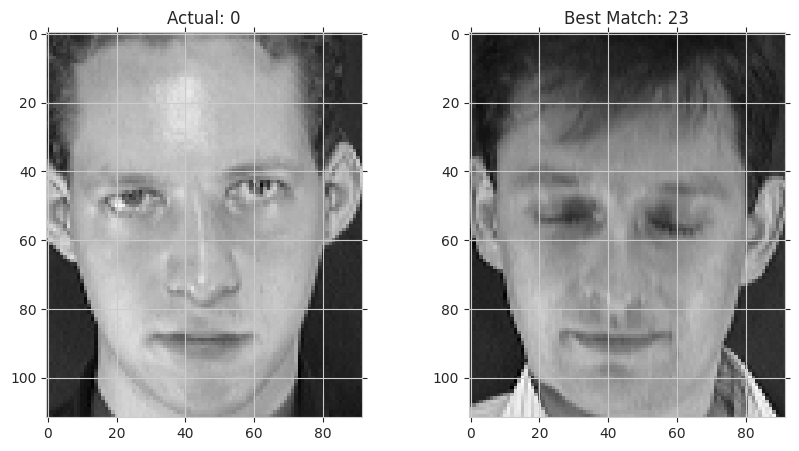

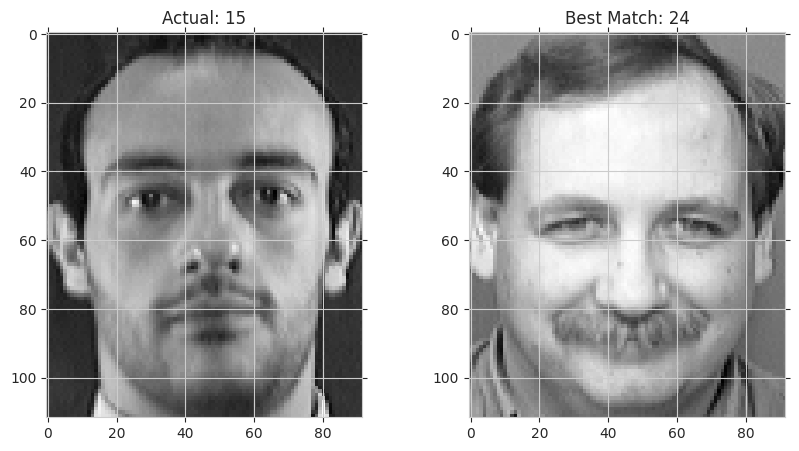

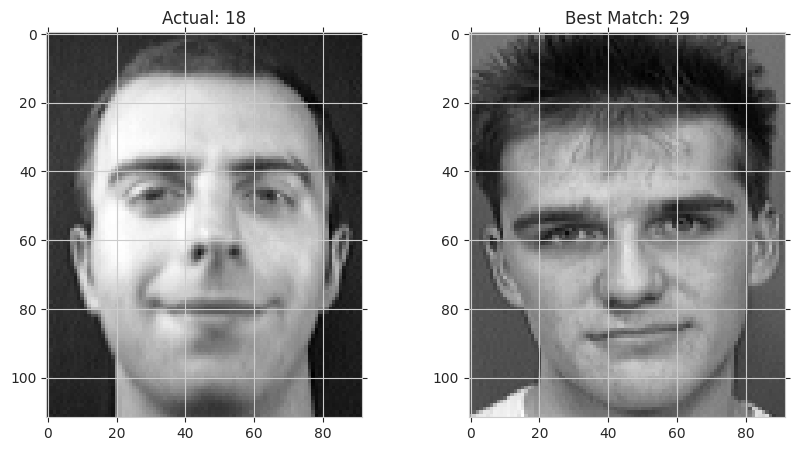

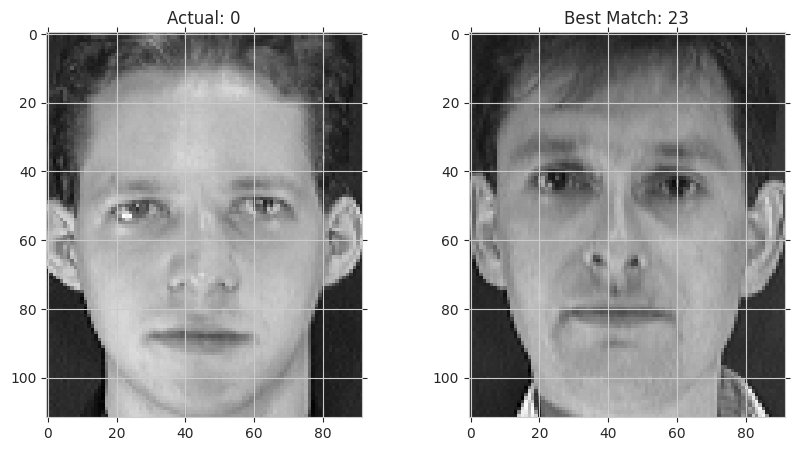

In [ ]:
clf = Distance_Classifier(method = 'mahalanobis')
clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)

print("accuracy score:{:.2f}%".format(accuracy_score(y_test, y_pred)*100))
clf.plot_best_match(X_train, X_test, X_test_pca, y_test)

In [ ]:
clf = Distance_Classifier(method = 'angle-based')
clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)
print("accuracy score:{:.2f}%".format(accuracy_score(y_test, y_pred)*100))

accuracy score:90.83%


In [ ]:
# clf = Distance_Classifier(method = 'mahalanobis')
# clf.fit(X_train_pca, y_train)
# y_pred = clf.predict(X_test_pca)
# print("accuracy score:{:.2f}%".format(metrics.accuracy_score(y_test, y_pred)*100))

- KNN

In [ ]:
class K_Nearest_Neighbors(Distance_Classifier):
      def __init__(self, method, neighbors=3):
          super().__init__(method)
          self.neighbors = neighbors

      def predict_single(self, data, only_prediction=True):
          # find the distances of the sample from the training faces
          distances = cal_distances(self.method, self.X, data)

          # find the index of the smallest distance
          sorted = np.argsort(distances)
          index = sorted[:self.neighbors]
          neighbors = np.array(self.y)[sorted][:self.neighbors]
          if len(np.unique(neighbors)) == len(neighbors):
            index = index[0]
            prediction = neighbors[0]
          else:
            prediction, counts = mode(neighbors)
            index = index[np.where(neighbors == prediction)[0][0]]

          if only_prediction:
              return prediction
          else:
              return {"prediction": prediction, "index": index, "distance": distances[index]}


In [ ]:
def performance_report(y_test, y_pred, cls):
    accuracy = accuracy_score(y_test, y_pred) * 100
    f1 = f1_score(y_test, y_pred, average='macro') * 100
    precision = precision_score(y_test, y_pred, average='macro') * 100
    recall = recall_score(y_test, y_pred, average='macro') * 100
    print("#"*80)
    print(f"Evaluate metrics for {cls} classifier:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"F1-score: {f1:.2f}%")
    print(f"Precision: {precision:.2f}%")
    print(f"Recall: {recall:.2f}%")


In [ ]:
def evaluate_models(X, y, test_size, stratify = True, n_components=200, is_scaler=True, is_show_metrics=True, using_knn=True, n_knn=5, classifier="euclidean"):
    predictions = {"pred":[], "true":[]}
    if stratify:
        X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=test_size, stratify=y, random_state=1511)
    else:
        X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=test_size, random_state=1511)

    if is_scaler:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    pca = PCA(n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    if using_knn:
        model = K_Nearest_Neighbors(method=classifier, neighbors=n_knn)
    else:
        model = Distance_Classifier(classifier)


    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)

    predictions["pred"].extend(y_pred)
    predictions["true"].extend(y_test)
    accuracy = accuracy_score(y_test, y_pred)
    # print(f"Average accuracy for {classifier} classifier: {accuracy}%")
    performance_report(y_test, y_pred, classifier)

    if is_show_metrics:
        model.plot_best_match(X_train, X_test, X_test_pca, y_test)
        ax = plt.axes()
        plt.suptitle(f"Confusion matrix for PCA / {classifier}")
        plt.title(f"Accuracy: {accuracy*100}%", fontsize=10)
        ConfusionMatrixDisplay.from_predictions(
            predictions["true"],
            predictions["pred"],
            xticks_rotation="vertical",
            include_values=False,
            normalize="true",
            display_labels=["" for i in range(len(set(predictions["true"])))],
            ax=ax)
        ax.tick_params(axis='both', which='both', length=0)
        plt.show()

################################################################################
Evaluate metrics for manhattan classifier:
Accuracy: 95.00%
F1-score: 94.70%
Precision: 96.50%
Recall: 95.00%
VISUALIZE ALL THE WRONGLY CLASSIFIED IMAGES


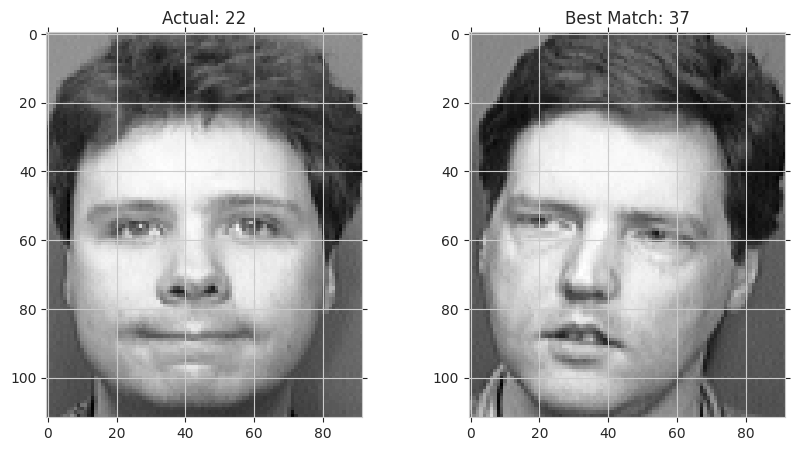

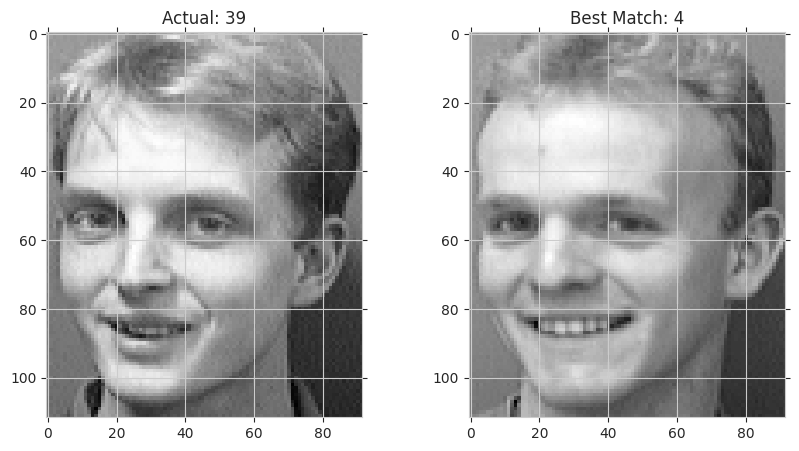

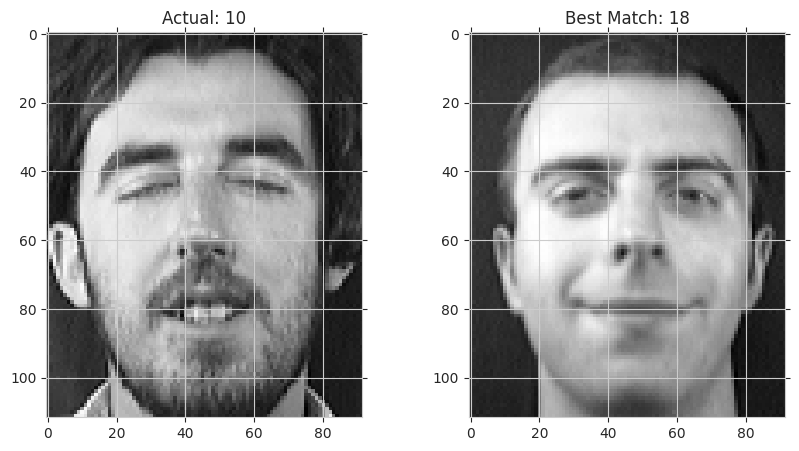

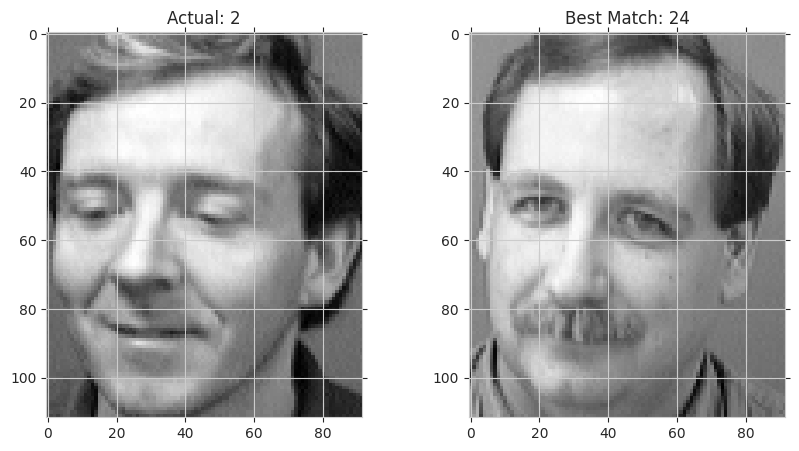

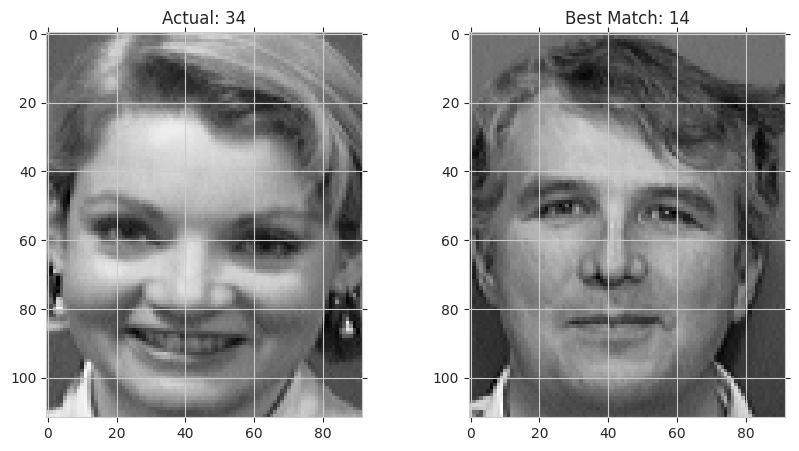

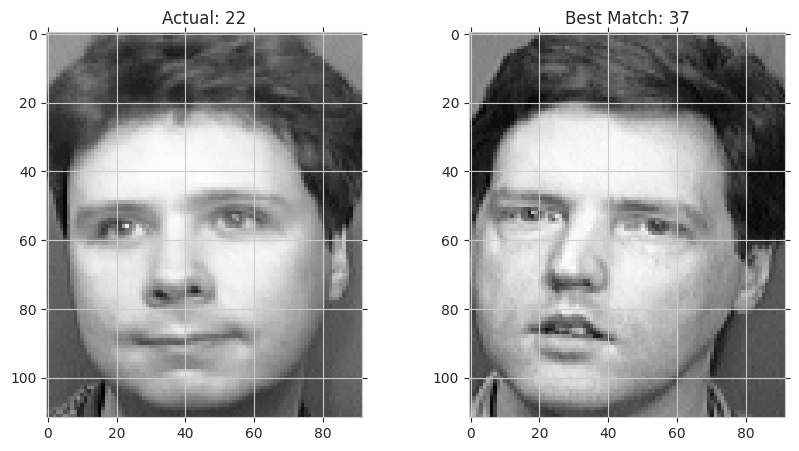

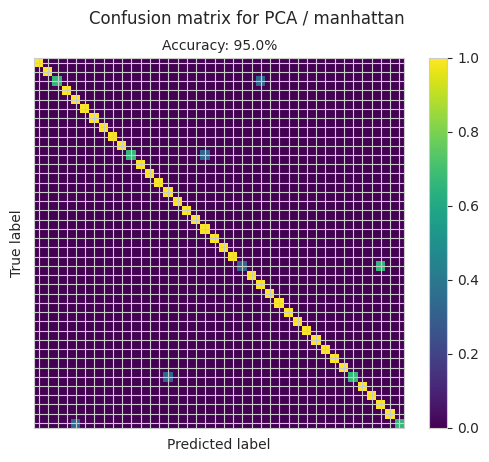

In [ ]:
evaluate_models(X, target, n_components=50, test_size= 0.3, stratify=True, is_scaler=False, is_show_metrics=True, using_knn=True, n_knn=3, classifier="manhattan")

In [ ]:
# metrics = ['euclidean', 'angle-based', 'modified-sse', 'mahalanobis', 'manhattan', 'sse', 'chi square', 'correlation coefficient-based', 'minkowski']
# for m in metrics:
#     evaluate_models(X, target, n_components=50, test_size= 0.3, stratify=True, is_scaler=False, is_show_metrics=False, using_knn=True,  n_knn=3, classifier=m)